In [1]:
import os
import numpy as np
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy

import wandb
import argparse
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import (
    AdamW, 
    get_linear_schedule_with_warmup,
    Wav2Vec2Config, 
    BertConfig,
    AutoTokenizer
)

from sklearn.model_selection import train_test_split

from dataset import ETRIDataset
from trainer import ModelTrainer
from models import (
    CASEAttentionModel, 
    CASECompressingModel,
    ConcatModel, 
    MultiModalMixer,
    TextOnlyModel,
    SpeechOnlyModel,
)
from utils import audio_embedding, seed, loss

def test(args):

    # seed number setting
    seed.seed_setting(args.seed)
    
    # Pass the config dictionary when you initialize W&B
    if args.mode == "train":
        wandb.init(project=args.wandb_project,
                group=args.wandb_group,
                entity=args.wandb_entity,
                name=args.wandb_name,
                config=args
        )

    def text_audio_collator(batch):
        """
            # Create a DataLoader that batches audio sequences and pads them to a fixed length
        """
        return {'audio_emb' : pad_sequence([item['audio_emb'] for item in batch], batch_first=True),
                'label' : torch.stack([item['label'] for item in batch]).squeeze(),
                'input_ids' :  torch.stack([item['input_ids'] for item in batch]).squeeze(),
                'attention_mask' :  torch.stack([item['attention_mask'] for item in batch]).squeeze(),
                'token_type_ids' :  torch.stack([item['token_type_ids'] for item in batch]).squeeze()}

    # label 변환
    label_dict = {'angry':0, 'neutral':1, 'sad':2, 'happy':3, 'disqust':4, 'surprise':5, 'fear':6}
    pet_label_dict = {'angry':'분노', 'neutral':'중립', 'sad':'슬픔', 'happy':'행복', 'disqust':'불쾌', 'surprise':'경이', 'fear':'공포'}

    # 각 Modality별 사전학습 모델의 config 반환
    wav_config = Wav2Vec2Config.from_pretrained(args.am_path)
    bert_config = BertConfig.from_pretrained(args.lm_path)
    tokenizer = AutoTokenizer.from_pretrained(args.lm_path)

    # -- Model Setting
    if args.model == "attention":
        model = CASEAttentionModel(args, wav_config, bert_config)
    elif args.model == "compressing":
        model = CASECompressingModel(args, wav_config, bert_config)
    elif args.model == "Concat":
        model = ConcatModel(args, wav_config, bert_config)
    elif args.model == "MMM":
        model = MultiModalMixer(args, wav_config, bert_config)
        # model.freeze()
    elif args.model == "text_only":
        model = TextOnlyModel(args, bert_config)
    elif args.model == "speech_only":
        model = SpeechOnlyModel(args, wav_config)
    
    # Test 수행
    if args.mode == "test":
        model.load_state_dict(torch.load(args.test_model_path))

        test_data = pd.read_csv(args.test_path)
        test_data.reset_index(inplace=True)

        test_audio_emb = audio_embedding.save_and_load(args.am_path, test_data['audio'].tolist(), args.device, args.test_embedding_path)

        test_dataset = ETRIDataset(
            audio_embedding = test_audio_emb, 
            dataset=test_data, 
            label_dict = label_dict,
            tokenizer = tokenizer,
            audio_emb_type = args.audio_emb_type,
            max_len = args.context_max_len, 
            pet=args.pet
            )
        
        test_dataloader = DataLoader(
            test_dataset, 
            batch_size=args.valid_bsz,
            shuffle=False, 
            collate_fn=text_audio_collator, 
            num_workers=args.num_workers,
            )
        
        trainer = ModelTrainer(
            args,
            model, loss_fn=None, optimizer=None, tokenizer=tokenizer,
            train_dataloader=None, valid_dataloader=None, test_dataloader=test_dataloader,
            scheduler = None,
            verbalizer_value=pet_label_dict if args.pet else None,
            label_dict = label_dict
            )

        e, s, m, m_f1, mic_f1, w_f1, acc = trainer.test()
        return e, s, m, m_f1, mic_f1, w_f1, acc
    
    # 이하 Train 수행

    dataset = pd.read_csv(args.train_path)
    dataset.reset_index(inplace=True)

    # embedding path가 존재할 경우, 불러오며 없을 경우 생성한다.
    audio_emb = audio_embedding.save_and_load(args.am_path, dataset['audio'].tolist(), args.device, args.embedding_path)

    # Train Dataset을 Train-Valid Dataset으로 나눈다.
    if args.val_ratio != 0:
        train_df, val_df = train_test_split(dataset, test_size = args.val_ratio, random_state=args.seed)
        
        train_dataset = ETRIDataset(
            audio_embedding = audio_emb, 
            dataset=train_df, 
            label_dict = label_dict,
            tokenizer = tokenizer,
            audio_emb_type = args.audio_emb_type,
            max_len = args.context_max_len, 
            pet=args.pet
            )
        
        val_dataset = ETRIDataset(
            audio_embedding = audio_emb, 
            dataset=val_df, 
            label_dict = label_dict,
            tokenizer = tokenizer,
            audio_emb_type = args.audio_emb_type,
            max_len = args.context_max_len, 
            pet=args.pet
            )

        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=args.train_bsz,
            shuffle=True, 
            collate_fn=text_audio_collator, 
            num_workers=args.num_workers,
            )
        
        valid_dataloader = DataLoader(
            val_dataset, 
            batch_size=args.valid_bsz,
            shuffle=False, 
            collate_fn=text_audio_collator, 
            num_workers=args.num_workers,
            )

    else:
        train_dataset = ETRIDataset(
            audio_embedding = audio_emb, 
            dataset=dataset, 
            label_dict = label_dict,
            tokenizer = tokenizer,
            audio_emb_type = args.audio_emb_type,
            max_len = args.context_max_len, 
            pet=args.pet
            )

        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=args.train_bsz,
            shuffle=True, 
            collate_fn=text_audio_collator, 
            num_workers=args.num_workers,
            )
        
        valid_dataloader = None
    
    # -- Loss Setting
    if args.loss == "focal":
        loss_fn = loss.FocalLoss(gamma = args.gamma)
    else:
        loss_fn=nn.CrossEntropyLoss()
        
    # -- Optimizer Setting
    optimizer = AdamW(
        model.parameters(),
        lr=args.lr,
        no_deprecation_warning=True
        )
    
    # -- Scheduler Setting
    scheduler = None
    if args.scheduler == "linear":
        total_steps = len(train_dataloader) * args.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps = total_steps * 0.1,
            num_training_steps = total_steps
        )

    trainer = ModelTrainer(
        args,
        model, loss_fn, optimizer, tokenizer,
        train_dataloader, valid_dataloader, test_dataloader=None,
        scheduler = scheduler,
        verbalizer_value=pet_label_dict if args.pet else None,
        label_dict = label_dict
        )
    trainer.train()

/home/jjonhwa/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:

# Define a config dictionary object
parser = argparse.ArgumentParser()

# -- Choose Pretrained Model
parser.add_argument("--lm_path", type=str, default="klue/bert-base", help="You can choose models among (klue-bert series and klue-roberta series) (default: klue/bert-base")
parser.add_argument("--am_path", type=str, default="kresnik/wav2vec2-large-xlsr-korean")

# -- Training Argument
parser.add_argument("--lr", type=float, default=2e-5)
parser.add_argument("--train_bsz", type=int, default=64)
parser.add_argument("--valid_bsz", type=int, default=64)
parser.add_argument("--val_ratio", type=float, default=0.2)
parser.add_argument("--context_max_len", type=int, default=128)
parser.add_argument("--audio_max_len", type=int, default=512)
parser.add_argument("--hidden_size", type=int, default=256)
parser.add_argument("--epochs", type=int, default=50)
parser.add_argument("--scheduler", type=str, default=None)
parser.add_argument("--pet", type=bool, default=False)
parser.add_argument("--loss", type=str, default="crossentropy")
parser.add_argument("--gamma", type=float, default=1.0, help="focalloss's gamma argument")

# -- Model Argument
parser.add_argument("--model", type=str, default="CASE")
parser.add_argument("--audio_emb_type", type=str, default="last_hidden_state", help="Can choose audio embedding type between 'last_hidden_state' and 'extract_features' (default: last_hidden_state)")
parser.add_argument("--opt", type=str, default='mean', help="Can choose operators type between 'mean' and 'sum'")
parser.add_argument("--mm_type", type=str, default='add', help="concat or add")
parser.add_argument("--num_labels", type=int, default=7)

## -- directory
parser.add_argument("--train_path", type=str, default="data/train.csv")
parser.add_argument("--test_path", type=str, default="data/test.csv")
parser.add_argument("--save_path", type=str, default="save")
parser.add_argument("--embedding_path", type=str, default="data/emb_train.pt")
parser.add_argument("--test_embedding_path", type=str, default="data/emb_test.pt")
parser.add_argument("--test_model_path", type=str, default="save/e150_compressing_seed0.pt")

# -- utils
parser.add_argument("--device", type=str, default="cuda:0")
parser.add_argument("--num_workers", type=int, default=4)
parser.add_argument("--seed", type=int, default=0)

# -- wandb
parser.add_argument("--wandb_project", type=str, default="comp")
parser.add_argument("--wandb_entity", type=str, default=None)
parser.add_argument("--wandb_group", type=str, default=None)
parser.add_argument("--wandb_name", type=str, default="case_audio_base")

## -- mode
parser.add_argument("--mode", type=str, default="train")

args = parser.parse_args([])

In [3]:
model_list = ["compressing", "compressing", "attention", "attention", "MMM", "Concat", "text_only", "speech_only"]
mm_list = ["add", "concat", "add", "concat", "concat", "concat", "concat", "concat"]
_seed = ["0", "42", "2023", "100", "1"]
epoch_list = ["30", "60", "90", "120", "150"]

dictionary = {
    "Model_Path": [],
    "Model": [],
    "Seed": [],
    "Epoch": [],
    "Macro-F1": [],
    "Micro-F1": [],
    "Weighted-F1": [],
    "Accuracy": []
}

args.mode = "test"
args.device = "cuda:1"
for i in range(len(model_list)):
    name = model_list[i]
    mm = mm_list[i]

    for _s in _seed:
        
        args.model = name
        args.mm_type = mm
        args.seed = int(_s)

        if name in ['compressing', 'attention'] and mm == "concat":
            model_name = name + '_' + mm
        else:
            model_name = name

        for epoch in epoch_list:
            
            test_path = f"save/e{epoch}_{model_name}_seed{_s}.pt"
            args.test_model_path = test_path

            e, s, m, m_f1, mic_f1, w_f1, acc = test(args)
            
            dictionary['Model_Path'].append(test_path)
            dictionary["Model"].append(model_name)
            dictionary["Seed"].append(s)
            dictionary["Epoch"].append(e)
            dictionary["Macro-F1"].append(m_f1)
            dictionary["Micro-F1"].append(mic_f1)
            dictionary["Weighted-F1"].append(w_f1)
            dictionary["Accuracy"].append(acc)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:09<00:00,  4.63it/s]


Epoch: 30, Seed: 0, Model: compressing, Macro-F1:  0.2410, Micro-F1:  0.3657, Weighted-F1:  0.8782, ACC:  0.9002


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.92it/s]


Epoch: 60, Seed: 0, Model: compressing, Macro-F1:  0.2707, Micro-F1:  0.4127, Weighted-F1:  0.8821, ACC:  0.8991


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 90, Seed: 0, Model: compressing, Macro-F1:  0.3005, Micro-F1:  0.4294, Weighted-F1:  0.8828, ACC:  0.8983


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.90it/s]


Epoch: 120, Seed: 0, Model: compressing, Macro-F1:  0.3251, Micro-F1:  0.4404, Weighted-F1:  0.8771, ACC:  0.8880


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.93it/s]


Epoch: 150, Seed: 0, Model: compressing, Macro-F1:  0.3206, Micro-F1:  0.4183, Weighted-F1:  0.8764, ACC:  0.8869


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 30, Seed: 42, Model: compressing, Macro-F1:  0.2408, Micro-F1:  0.3601, Weighted-F1:  0.8778, ACC:  0.9002


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.92it/s]


Epoch: 60, Seed: 42, Model: compressing, Macro-F1:  0.2772, Micro-F1:  0.3961, Weighted-F1:  0.8781, ACC:  0.8949


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.92it/s]


Epoch: 90, Seed: 42, Model: compressing, Macro-F1:  0.2884, Micro-F1:  0.3657, Weighted-F1:  0.8793, ACC:  0.8991


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.92it/s]


Epoch: 120, Seed: 42, Model: compressing, Macro-F1:  0.3252, Micro-F1:  0.4321, Weighted-F1:  0.8800, ACC:  0.8941


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.92it/s]


Epoch: 150, Seed: 42, Model: compressing, Macro-F1:  0.3157, Micro-F1:  0.4238, Weighted-F1:  0.8784, ACC:  0.8922


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 30, Seed: 2023, Model: compressing, Macro-F1:  0.2317, Micro-F1:  0.3684, Weighted-F1:  0.8765, ACC:  0.8983


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 60, Seed: 2023, Model: compressing, Macro-F1:  0.2666, Micro-F1:  0.3740, Weighted-F1:  0.8816, ACC:  0.9013


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 90, Seed: 2023, Model: compressing, Macro-F1:  0.2930, Micro-F1:  0.4294, Weighted-F1:  0.8811, ACC:  0.8972


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 120, Seed: 2023, Model: compressing, Macro-F1:  0.3138, Micro-F1:  0.4155, Weighted-F1:  0.8783, ACC:  0.8911


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.90it/s]


Epoch: 150, Seed: 2023, Model: compressing, Macro-F1:  0.3290, Micro-F1:  0.4211, Weighted-F1:  0.8823, ACC:  0.8964


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 30, Seed: 0, Model: compressing, Macro-F1:  0.2311, Micro-F1:  0.3657, Weighted-F1:  0.8778, ACC:  0.9009


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.88it/s]


Epoch: 60, Seed: 0, Model: compressing, Macro-F1:  0.2689, Micro-F1:  0.4072, Weighted-F1:  0.8818, ACC:  0.8994


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 90, Seed: 0, Model: compressing, Macro-F1:  0.3065, Micro-F1:  0.4183, Weighted-F1:  0.8824, ACC:  0.8987


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 120, Seed: 0, Model: compressing, Macro-F1:  0.3155, Micro-F1:  0.4598, Weighted-F1:  0.8820, ACC:  0.8930


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 150, Seed: 0, Model: compressing, Macro-F1:  0.3130, Micro-F1:  0.4211, Weighted-F1:  0.8816, ACC:  0.8941


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.90it/s]


Epoch: 30, Seed: 42, Model: compressing, Macro-F1:  0.2485, Micro-F1:  0.3740, Weighted-F1:  0.8783, ACC:  0.8998


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 60, Seed: 42, Model: compressing, Macro-F1:  0.2737, Micro-F1:  0.4100, Weighted-F1:  0.8812, ACC:  0.8979


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 90, Seed: 42, Model: compressing, Macro-F1:  0.3108, Micro-F1:  0.3934, Weighted-F1:  0.8845, ACC:  0.9028


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.88it/s]


Epoch: 120, Seed: 42, Model: compressing, Macro-F1:  0.3130, Micro-F1:  0.4404, Weighted-F1:  0.8855, ACC:  0.9006


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.92it/s]


Epoch: 150, Seed: 42, Model: compressing, Macro-F1:  0.3059, Micro-F1:  0.4404, Weighted-F1:  0.8808, ACC:  0.8934


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 30, Seed: 2023, Model: compressing, Macro-F1:  0.2343, Micro-F1:  0.3850, Weighted-F1:  0.8782, ACC:  0.8994


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 60, Seed: 2023, Model: compressing, Macro-F1:  0.2782, Micro-F1:  0.3878, Weighted-F1:  0.8812, ACC:  0.8998


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.95it/s]


Epoch: 90, Seed: 2023, Model: compressing, Macro-F1:  0.3138, Micro-F1:  0.4432, Weighted-F1:  0.8846, ACC:  0.8998


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.94it/s]


Epoch: 120, Seed: 2023, Model: compressing, Macro-F1:  0.3196, Micro-F1:  0.4377, Weighted-F1:  0.8813, ACC:  0.8941


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.93it/s]


Epoch: 150, Seed: 2023, Model: compressing, Macro-F1:  0.3174, Micro-F1:  0.4183, Weighted-F1:  0.8827, ACC:  0.8975


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.29it/s]


Epoch: 30, Seed: 0, Model: attention, Macro-F1:  0.2402, Micro-F1:  0.3712, Weighted-F1:  0.8745, ACC:  0.8949


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 60, Seed: 0, Model: attention, Macro-F1:  0.2788, Micro-F1:  0.3463, Weighted-F1:  0.8672, ACC:  0.8843


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.27it/s]


Epoch: 90, Seed: 0, Model: attention, Macro-F1:  0.2735, Micro-F1:  0.4044, Weighted-F1:  0.8711, ACC:  0.8839


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.29it/s]


Epoch: 120, Seed: 0, Model: attention, Macro-F1:  0.2585, Micro-F1:  0.3657, Weighted-F1:  0.8678, ACC:  0.8835


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.27it/s]


Epoch: 150, Seed: 0, Model: attention, Macro-F1:  0.2934, Micro-F1:  0.3823, Weighted-F1:  0.8715, ACC:  0.8869


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.29it/s]


Epoch: 30, Seed: 42, Model: attention, Macro-F1:  0.2464, Micro-F1:  0.3823, Weighted-F1:  0.8642, ACC:  0.8793


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 60, Seed: 42, Model: attention, Macro-F1:  0.2862, Micro-F1:  0.3934, Weighted-F1:  0.8700, ACC:  0.8846


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.31it/s]


Epoch: 90, Seed: 42, Model: attention, Macro-F1:  0.2708, Micro-F1:  0.3961, Weighted-F1:  0.8634, ACC:  0.8721


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 120, Seed: 42, Model: attention, Macro-F1:  0.2914, Micro-F1:  0.4072, Weighted-F1:  0.8650, ACC:  0.8748


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.29it/s]


Epoch: 150, Seed: 42, Model: attention, Macro-F1:  0.2718, Micro-F1:  0.3767, Weighted-F1:  0.8662, ACC:  0.8797


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.29it/s]


Epoch: 30, Seed: 2023, Model: attention, Macro-F1:  0.2439, Micro-F1:  0.3795, Weighted-F1:  0.8669, ACC:  0.8839


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.31it/s]


Epoch: 60, Seed: 2023, Model: attention, Macro-F1:  0.2719, Micro-F1:  0.3989, Weighted-F1:  0.8681, ACC:  0.8797


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 90, Seed: 2023, Model: attention, Macro-F1:  0.2652, Micro-F1:  0.3767, Weighted-F1:  0.8715, ACC:  0.8854


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.32it/s]


Epoch: 120, Seed: 2023, Model: attention, Macro-F1:  0.2783, Micro-F1:  0.4127, Weighted-F1:  0.8721, ACC:  0.8831


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.28it/s]


Epoch: 150, Seed: 2023, Model: attention, Macro-F1:  0.2671, Micro-F1:  0.4321, Weighted-F1:  0.8666, ACC:  0.8710


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.28it/s]


Epoch: 30, Seed: 0, Model: attention, Macro-F1:  0.2448, Micro-F1:  0.3961, Weighted-F1:  0.8686, ACC:  0.8861


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.32it/s]


Epoch: 60, Seed: 0, Model: attention, Macro-F1:  0.2800, Micro-F1:  0.4266, Weighted-F1:  0.8657, ACC:  0.8748


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 90, Seed: 0, Model: attention, Macro-F1:  0.2681, Micro-F1:  0.3740, Weighted-F1:  0.8721, ACC:  0.8865


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 120, Seed: 0, Model: attention, Macro-F1:  0.3090, Micro-F1:  0.3657, Weighted-F1:  0.8711, ACC:  0.8861


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.29it/s]


Epoch: 150, Seed: 0, Model: attention, Macro-F1:  0.3045, Micro-F1:  0.3878, Weighted-F1:  0.8751, ACC:  0.8877


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.31it/s]


Epoch: 30, Seed: 42, Model: attention, Macro-F1:  0.2460, Micro-F1:  0.4017, Weighted-F1:  0.8721, ACC:  0.8903


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 60, Seed: 42, Model: attention, Macro-F1:  0.2627, Micro-F1:  0.3989, Weighted-F1:  0.8667, ACC:  0.8786


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 90, Seed: 42, Model: attention, Macro-F1:  0.2526, Micro-F1:  0.3906, Weighted-F1:  0.8604, ACC:  0.8702


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.28it/s]


Epoch: 120, Seed: 42, Model: attention, Macro-F1:  0.2505, Micro-F1:  0.3601, Weighted-F1:  0.8639, ACC:  0.8774


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.28it/s]


Epoch: 150, Seed: 42, Model: attention, Macro-F1:  0.2886, Micro-F1:  0.4072, Weighted-F1:  0.8615, ACC:  0.8687


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 30, Seed: 2023, Model: attention, Macro-F1:  0.2339, Micro-F1:  0.3961, Weighted-F1:  0.8701, ACC:  0.8880


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.29it/s]


Epoch: 60, Seed: 2023, Model: attention, Macro-F1:  0.2678, Micro-F1:  0.4017, Weighted-F1:  0.8683, ACC:  0.8820


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.29it/s]


Epoch: 90, Seed: 2023, Model: attention, Macro-F1:  0.2781, Micro-F1:  0.3934, Weighted-F1:  0.8680, ACC:  0.8801


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.30it/s]


Epoch: 120, Seed: 2023, Model: attention, Macro-F1:  0.2581, Micro-F1:  0.3878, Weighted-F1:  0.8698, ACC:  0.8839


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.27it/s]


Epoch: 150, Seed: 2023, Model: attention, Macro-F1:  0.2507, Micro-F1:  0.4072, Weighted-F1:  0.8606, ACC:  0.8691


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.91it/s]


Epoch: 30, Seed: 0, Model: MMM, Macro-F1:  0.2980, Micro-F1:  0.4238, Weighted-F1:  0.8695, ACC:  0.8805


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 60, Seed: 0, Model: MMM, Macro-F1:  0.3052, Micro-F1:  0.4183, Weighted-F1:  0.8655, ACC:  0.8744


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.90it/s]


Epoch: 90, Seed: 0, Model: MMM, Macro-F1:  0.2904, Micro-F1:  0.3823, Weighted-F1:  0.8628, ACC:  0.8751


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.88it/s]


Epoch: 120, Seed: 0, Model: MMM, Macro-F1:  0.3015, Micro-F1:  0.3961, Weighted-F1:  0.8699, ACC:  0.8816


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 150, Seed: 0, Model: MMM, Macro-F1:  0.2993, Micro-F1:  0.4017, Weighted-F1:  0.8674, ACC:  0.8782


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.90it/s]


Epoch: 30, Seed: 42, Model: MMM, Macro-F1:  0.3187, Micro-F1:  0.4598, Weighted-F1:  0.8773, ACC:  0.8865


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.87it/s]


Epoch: 60, Seed: 42, Model: MMM, Macro-F1:  0.2820, Micro-F1:  0.4127, Weighted-F1:  0.8702, ACC:  0.8816


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.88it/s]


Epoch: 90, Seed: 42, Model: MMM, Macro-F1:  0.2978, Micro-F1:  0.4321, Weighted-F1:  0.8748, ACC:  0.8858


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 120, Seed: 42, Model: MMM, Macro-F1:  0.3023, Micro-F1:  0.4155, Weighted-F1:  0.8728, ACC:  0.8850


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.90it/s]


Epoch: 150, Seed: 42, Model: MMM, Macro-F1:  0.3039, Micro-F1:  0.4100, Weighted-F1:  0.8776, ACC:  0.8918


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.90it/s]


Epoch: 30, Seed: 2023, Model: MMM, Macro-F1:  0.2950, Micro-F1:  0.4211, Weighted-F1:  0.8627, ACC:  0.8698


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.90it/s]


Epoch: 60, Seed: 2023, Model: MMM, Macro-F1:  0.2862, Micro-F1:  0.4072, Weighted-F1:  0.8617, ACC:  0.8702


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 90, Seed: 2023, Model: MMM, Macro-F1:  0.2988, Micro-F1:  0.4072, Weighted-F1:  0.8703, ACC:  0.8827


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.88it/s]


Epoch: 120, Seed: 2023, Model: MMM, Macro-F1:  0.2966, Micro-F1:  0.3989, Weighted-F1:  0.8727, ACC:  0.8861


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.89it/s]


Epoch: 150, Seed: 2023, Model: MMM, Macro-F1:  0.2978, Micro-F1:  0.3878, Weighted-F1:  0.8734, ACC:  0.8884


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.99it/s]


Epoch: 30, Seed: 0, Model: Concat, Macro-F1:  0.2160, Micro-F1:  0.3269, Weighted-F1:  0.8701, ACC:  0.8956


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  4.99it/s]


Epoch: 60, Seed: 0, Model: Concat, Macro-F1:  0.2596, Micro-F1:  0.3934, Weighted-F1:  0.8818, ACC:  0.9021


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.01it/s]


Epoch: 90, Seed: 0, Model: Concat, Macro-F1:  0.2750, Micro-F1:  0.4349, Weighted-F1:  0.8804, ACC:  0.8941


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.02it/s]


Epoch: 120, Seed: 0, Model: Concat, Macro-F1:  0.3133, Micro-F1:  0.4571, Weighted-F1:  0.8803, ACC:  0.8911


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.04it/s]


Epoch: 150, Seed: 0, Model: Concat, Macro-F1:  0.2995, Micro-F1:  0.4488, Weighted-F1:  0.8745, ACC:  0.8831


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.03it/s]


Epoch: 30, Seed: 42, Model: Concat, Macro-F1:  0.2235, Micro-F1:  0.4044, Weighted-F1:  0.8764, ACC:  0.8975


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.04it/s]


Epoch: 60, Seed: 42, Model: Concat, Macro-F1:  0.2511, Micro-F1:  0.3795, Weighted-F1:  0.8804, ACC:  0.9017


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.03it/s]


Epoch: 90, Seed: 42, Model: Concat, Macro-F1:  0.2509, Micro-F1:  0.4349, Weighted-F1:  0.8786, ACC:  0.8956


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.03it/s]


Epoch: 120, Seed: 42, Model: Concat, Macro-F1:  0.2906, Micro-F1:  0.3740, Weighted-F1:  0.8800, ACC:  0.8979


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.03it/s]


Epoch: 150, Seed: 42, Model: Concat, Macro-F1:  0.2859, Micro-F1:  0.3906, Weighted-F1:  0.8737, ACC:  0.8896


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.01it/s]


Epoch: 30, Seed: 2023, Model: Concat, Macro-F1:  0.2187, Micro-F1:  0.3407, Weighted-F1:  0.8722, ACC:  0.8972


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.02it/s]


Epoch: 60, Seed: 2023, Model: Concat, Macro-F1:  0.2493, Micro-F1:  0.4155, Weighted-F1:  0.8807, ACC:  0.9002


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.01it/s]


Epoch: 90, Seed: 2023, Model: Concat, Macro-F1:  0.2914, Micro-F1:  0.4211, Weighted-F1:  0.8811, ACC:  0.8964


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.05it/s]


Epoch: 120, Seed: 2023, Model: Concat, Macro-F1:  0.3076, Micro-F1:  0.4792, Weighted-F1:  0.8757, ACC:  0.8854


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:08<00:00,  5.04it/s]


Epoch: 150, Seed: 2023, Model: Concat, Macro-F1:  0.2978, Micro-F1:  0.4266, Weighted-F1:  0.8757, ACC:  0.8858


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.44it/s]


Epoch: 30, Seed: 0, Model: text, Macro-F1:  0.1335, Micro-F1:  0.0028, Weighted-F1:  0.8005, ACC:  0.8634


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.43it/s]


Epoch: 60, Seed: 0, Model: text, Macro-F1:  0.1324, Micro-F1:  0.0000, Weighted-F1:  0.7995, ACC:  0.8630


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.44it/s]


Epoch: 90, Seed: 0, Model: text, Macro-F1:  0.1445, Micro-F1:  0.0055, Weighted-F1:  0.8013, ACC:  0.8638


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.42it/s]


Epoch: 120, Seed: 0, Model: text, Macro-F1:  0.1456, Micro-F1:  0.0083, Weighted-F1:  0.8023, ACC:  0.8641


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.45it/s]


Epoch: 150, Seed: 0, Model: text, Macro-F1:  0.1456, Micro-F1:  0.0083, Weighted-F1:  0.8021, ACC:  0.8638


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.43it/s]


Epoch: 30, Seed: 42, Model: text, Macro-F1:  0.1334, Micro-F1:  0.0028, Weighted-F1:  0.7999, ACC:  0.8622


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.43it/s]


Epoch: 60, Seed: 42, Model: text, Macro-F1:  0.1323, Micro-F1:  0.0000, Weighted-F1:  0.7992, ACC:  0.8622


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.46it/s]


Epoch: 90, Seed: 42, Model: text, Macro-F1:  0.1433, Micro-F1:  0.0028, Weighted-F1:  0.8000, ACC:  0.8626


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.45it/s]


Epoch: 120, Seed: 42, Model: text, Macro-F1:  0.1445, Micro-F1:  0.0055, Weighted-F1:  0.8012, ACC:  0.8634


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.44it/s]


Epoch: 150, Seed: 42, Model: text, Macro-F1:  0.1467, Micro-F1:  0.0111, Weighted-F1:  0.8032, ACC:  0.8645


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.42it/s]


Epoch: 30, Seed: 2023, Model: text, Macro-F1:  0.1334, Micro-F1:  0.0028, Weighted-F1:  0.8003, ACC:  0.8630


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.44it/s]


Epoch: 60, Seed: 2023, Model: text, Macro-F1:  0.1334, Micro-F1:  0.0028, Weighted-F1:  0.8001, ACC:  0.8626


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.44it/s]


Epoch: 90, Seed: 2023, Model: text, Macro-F1:  0.1334, Micro-F1:  0.0028, Weighted-F1:  0.8003, ACC:  0.8630


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.43it/s]


Epoch: 120, Seed: 2023, Model: text, Macro-F1:  0.1434, Micro-F1:  0.0028, Weighted-F1:  0.8004, ACC:  0.8634


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 42/42 [00:07<00:00,  5.41it/s]


Epoch: 150, Seed: 2023, Model: text, Macro-F1:  0.1445, Micro-F1:  0.0055, Weighted-F1:  0.8013, ACC:  0.8638


100%|██████████| 42/42 [00:03<00:00, 10.75it/s]


Epoch: 30, Seed: 0, Model: speech, Macro-F1:  0.1479, Micro-F1:  0.0416, Weighted-F1:  0.8116, ACC:  0.8668


100%|██████████| 42/42 [00:03<00:00, 10.76it/s]


Epoch: 60, Seed: 0, Model: speech, Macro-F1:  0.1662, Micro-F1:  0.0997, Weighted-F1:  0.8260, ACC:  0.8717


100%|██████████| 42/42 [00:04<00:00, 10.06it/s]


Epoch: 90, Seed: 0, Model: speech, Macro-F1:  0.1718, Micro-F1:  0.1191, Weighted-F1:  0.8307, ACC:  0.8740


100%|██████████| 42/42 [00:03<00:00, 10.61it/s]


Epoch: 120, Seed: 0, Model: speech, Macro-F1:  0.1786, Micro-F1:  0.1440, Weighted-F1:  0.8363, ACC:  0.8767


100%|██████████| 42/42 [00:03<00:00, 10.70it/s]


Epoch: 150, Seed: 0, Model: speech, Macro-F1:  0.1795, Micro-F1:  0.1468, Weighted-F1:  0.8373, ACC:  0.8774


100%|██████████| 42/42 [00:03<00:00, 10.78it/s]


Epoch: 30, Seed: 42, Model: speech, Macro-F1:  0.1499, Micro-F1:  0.0471, Weighted-F1:  0.8133, ACC:  0.8676


100%|██████████| 42/42 [00:04<00:00,  9.64it/s]


Epoch: 60, Seed: 42, Model: speech, Macro-F1:  0.1669, Micro-F1:  0.1025, Weighted-F1:  0.8264, ACC:  0.8717


100%|██████████| 42/42 [00:03<00:00, 10.62it/s]


Epoch: 90, Seed: 42, Model: speech, Macro-F1:  0.1750, Micro-F1:  0.1302, Weighted-F1:  0.8335, ACC:  0.8755


100%|██████████| 42/42 [00:03<00:00, 10.63it/s]


Epoch: 120, Seed: 42, Model: speech, Macro-F1:  0.1778, Micro-F1:  0.1413, Weighted-F1:  0.8357, ACC:  0.8763


100%|██████████| 42/42 [00:03<00:00, 10.71it/s]


Epoch: 150, Seed: 42, Model: speech, Macro-F1:  0.1814, Micro-F1:  0.1551, Weighted-F1:  0.8387, ACC:  0.8778


100%|██████████| 42/42 [00:03<00:00, 10.62it/s]


Epoch: 30, Seed: 2023, Model: speech, Macro-F1:  0.1471, Micro-F1:  0.0388, Weighted-F1:  0.8112, ACC:  0.8672


100%|██████████| 42/42 [00:03<00:00, 10.67it/s]


Epoch: 60, Seed: 2023, Model: speech, Macro-F1:  0.1669, Micro-F1:  0.1025, Weighted-F1:  0.8264, ACC:  0.8717


100%|██████████| 42/42 [00:03<00:00, 10.62it/s]


Epoch: 90, Seed: 2023, Model: speech, Macro-F1:  0.1763, Micro-F1:  0.1357, Weighted-F1:  0.8343, ACC:  0.8755


100%|██████████| 42/42 [00:03<00:00, 10.55it/s]


Epoch: 120, Seed: 2023, Model: speech, Macro-F1:  0.1793, Micro-F1:  0.1468, Weighted-F1:  0.8370, ACC:  0.8770


100%|██████████| 42/42 [00:03<00:00, 10.66it/s]

Epoch: 150, Seed: 2023, Model: speech, Macro-F1:  0.1836, Micro-F1:  0.1634, Weighted-F1:  0.8407, ACC:  0.8789


In [41]:
data = pd.DataFrame(dictionary)

In [42]:
data_compressing_0 = data[(data['Model'] == "compressing") & (data['Seed'] == "0")]
data_compressing_42 = data[(data['Model'] == "compressing") & (data['Seed'] == "42")]
data_compressing_2023 = data[(data['Model'] == "compressing") & (data['Seed'] == "2023")]

data_compressing_concat_0 = data[(data['Model'] == "compressing_concat") & (data['Seed'] == "0")]
data_compressing_concat_42 = data[(data['Model'] == "compressing_concat") & (data['Seed'] == "42")]
data_compressing_concat_2023 = data[(data['Model'] == "compressing_concat") & (data['Seed'] == "2023")]

data_attention_0 = data[(data['Model'] == "attention") & (data['Seed'] == "0")]
data_attention_42 = data[(data['Model'] == "attention") & (data['Seed'] == "42")]
data_attention_2023 = data[(data['Model'] == "attention") & (data['Seed'] == "2023")]

data_attention_concat_0 = data[(data['Model'] == "attention_concat") & (data['Seed'] == "0")]
data_attention_concat_42 = data[(data['Model'] == "attention_concat") & (data['Seed'] == "42")]
data_attention_concat_2023 = data[(data['Model'] == "attention_concat") & (data['Seed'] == "2023")]

data_concat_0 = data[(data['Model'] == "Concat") & (data['Seed'] == "0")]
data_concat_42 = data[(data['Model'] == "Concat") & (data['Seed'] == "42")]
data_concat_2023 = data[(data['Model'] == "Concat") & (data['Seed'] == "2023")]

data_MMM_0 = data[(data['Model'] == "MMM") & (data['Seed'] == "0")]
data_MMM_42 = data[(data['Model'] == "MMM") & (data['Seed'] == "42")]
data_MMM_2023 = data[(data['Model'] == "MMM") & (data['Seed'] == "2023")]

data_text_only_0 = data[(data['Model'] == "text_only") & (data['Seed'] == "0")]
data_text_only_42 = data[(data['Model'] == "text_only") & (data['Seed'] == "42")]
data_text_only_2023 = data[(data['Model'] == "text_only") & (data['Seed'] == "2023")]

data_speech_only_0 = data[(data['Model'] == "speech_only") & (data['Seed'] == "0")]
data_speech_only_42 = data[(data['Model'] == "speech_only") & (data['Seed'] == "42")]
data_speech_only_2023 = data[(data['Model'] == "speech_only") & (data['Seed'] == "2023")]

In [43]:
data_compressing_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_compressing_0 = data_compressing_0.reset_index(drop=True)
data_compressing_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_compressing_42 = data_compressing_42.reset_index(drop=True)
data_compressing_2023.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_compressing_2023 = data_compressing_2023.reset_index(drop=True)

data_compressing_concat_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_compressing_concat_0 = data_compressing_concat_0.reset_index(drop=True)
data_compressing_concat_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_compressing_concat_42 = data_compressing_concat_42.reset_index(drop=True)
data_compressing_concat_2023.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_compressing_concat_2023 = data_compressing_concat_2023.reset_index(drop=True)

data_attention_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_attention_0 = data_attention_0.reset_index(drop=True)
data_attention_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_attention_42 = data_attention_42.reset_index(drop=True)
data_attention_2023.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_attention_2023 = data_attention_2023.reset_index(drop=True)

data_attention_concat_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_attention_concat_0 = data_attention_concat_0.reset_index(drop=True)
data_attention_concat_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_attention_concat_42 = data_attention_concat_42.reset_index(drop=True)
data_attention_concat_2023.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_attention_concat_2023 = data_attention_concat_2023.reset_index(drop=True)

data_concat_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_concat_0 = data_concat_0.reset_index(drop=True)
data_concat_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_concat_42 = data_concat_42.reset_index(drop=True)
data_concat_2023.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_concat_2023 = data_concat_2023.reset_index(drop=True)

data_MMM_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_MMM_0 = data_MMM_0.reset_index(drop=True)
data_MMM_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_MMM_42 = data_MMM_42.reset_index(drop=True)
data_MMM_2023.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_MMM_2023 = data_MMM_2023.reset_index(drop=True)

data_text_only_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_text_only_0 = data_text_only_0.reset_index(drop=True)
data_text_only_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_text_only_42 = data_text_only_42.reset_index(drop=True)
data_text_only_2023.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_text_only_2023 = data_text_only_2023.reset_index(drop=True)

data_speech_only_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_speech_only_0 = data_speech_only_0.reset_index(drop=True)
data_speech_only_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_speech_only_42 = data_speech_only_42.reset_index(drop=True)
data_speech_only_2023.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
data_speech_only_2023 = data_speech_only_2023.reset_index(drop=True)

/tmp/ipykernel_699246/1233977263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_compressing_0.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
/tmp/ipykernel_699246/1233977263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_compressing_42.drop(["Model", "Seed", "Epoch", "Model_Path"], axis=1, inplace=True)
/tmp/ipykernel_699246/1233977263.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_co

In [44]:
data_compressing = (data_compressing_0 + data_compressing_42 + data_compressing_2023) / 3
data_compressing_concat = (data_compressing_concat_0 + data_compressing_concat_42 + data_compressing_concat_2023) / 3
data_attention = (data_attention_0 + data_attention_42 + data_attention_2023) / 3
data_attention_concat = (data_attention_concat_0 + data_attention_concat_42 + data_attention_concat_2023) / 3
data_concat = (data_concat_0 + data_concat_42 + data_concat_2023) / 3
data_mmm = (data_MMM_0 + data_MMM_42 + data_MMM_2023) / 3
data_text = (data_text_only_0 + data_text_only_42 + data_text_only_2023) / 3
data_speech = (data_speech_only_0 + data_speech_only_42 + data_speech_only_2023) / 3

In [45]:
from matplotlib import pyplot as plt

In [46]:
print(f"Compressing Macro-F1: {data_compressing['Macro-F1'][3]: .4f}")
print(f"Compressing Micro-F1: {data_compressing['Micro-F1'][3]: .4f}")
print(f"Compressing Weighted-F1: {data_compressing['Weighted-F1'][3]: .4f}")

print()
print(f"attention Macro-F1: {data_attention['Macro-F1'][3]: .4f}")
print(f"attention Micro-F1: {data_attention['Micro-F1'][3]: .4f}")
print(f"attention Weighted-F1: {data_attention['Weighted-F1'][3]: .4f}")

print()
print(f"concat Macro-F1: {data_concat['Macro-F1'][3]: .4f}")
print(f"concat Micro-F1: {data_concat['Micro-F1'][3]: .4f}")
print(f"concat Weighted-F1: {data_concat['Weighted-F1'][3]: .4f}")

print()
print(f"mmm Macro-F1: {data_mmm['Macro-F1'][3]: .4f}")
print(f"mmm Micro-F1: {data_mmm['Micro-F1'][3]: .4f}")
print(f"mmm Weighted-F1: {data_mmm['Weighted-F1'][3]: .4f}")

print()
print(f"Compressing_concat Macro-F1: {data_compressing_concat['Macro-F1'][3]: .4f}")
print(f"Compressing_concat Micro-F1: {data_compressing_concat['Micro-F1'][3]: .4f}")
print(f"Compressing_concat Weighted-F1: {data_compressing_concat['Weighted-F1'][3]: .4f}")

print()
print(f"attention_concat Macro-F1: {data_attention_concat['Macro-F1'][3]: .4f}")
print(f"attention_concat Micro-F1: {data_attention_concat['Micro-F1'][3]: .4f}")
print(f"attention_concat Weighted-F1: {data_attention_concat['Weighted-F1'][3]: .4f}")

print()
print(f"text Macro-F1: {data_text['Macro-F1'][3]: .4f}")
print(f"text Micro-F1: {data_text['Micro-F1'][3]: .4f}")
print(f"text Weighted-F1: {data_text['Weighted-F1'][3]: .4f}")

print()
print(f"speech Macro-F1: {data_speech['Macro-F1'][3]: .4f}")
print(f"speech Micro-F1: {data_speech['Micro-F1'][3]: .4f}")
print(f"speech Weighted-F1: {data_speech['Weighted-F1'][3]: .4f}")


Compressing Macro-F1:  0.3214
Compressing Micro-F1:  0.4294
Compressing Weighted-F1:  0.8785

attention Macro-F1:  0.2760
attention Micro-F1:  0.3952
attention Weighted-F1:  0.8683

concat Macro-F1:  0.3039
concat Micro-F1:  0.4367
concat Weighted-F1:  0.8787

mmm Macro-F1:  0.3001
mmm Micro-F1:  0.4035
mmm Weighted-F1:  0.8718

Compressing_concat Macro-F1:  0.3160
Compressing_concat Micro-F1:  0.4460
Compressing_concat Weighted-F1:  0.8830

attention_concat Macro-F1:  0.2725
attention_concat Micro-F1:  0.3712
attention_concat Weighted-F1:  0.8683

text Macro-F1:  0.1445
text Micro-F1:  0.0055
text Weighted-F1:  0.8013

speech Macro-F1:  0.1786
speech Micro-F1:  0.1440
speech Weighted-F1:  0.8363


([<matplotlib.axis.XTick at 0x7fa293f2b370>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

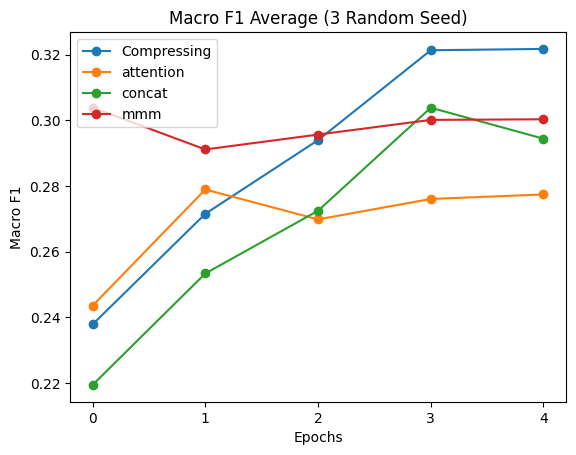

In [25]:
plt.plot(data_compressing['Macro-F1'], marker="o", label="Compressing")
plt.plot(data_attention['Macro-F1'], marker="o", label="attention")
plt.plot(data_concat['Macro-F1'], marker="o", label="concat")
plt.plot(data_mmm['Macro-F1'], marker="o", label="mmm")

plt.title("Macro F1 Average (3 Random Seed)")
plt.xlabel("Epochs")
plt.ylabel("Macro F1")
plt.legend(loc = "upper left")
plt.xticks(data_compressing.index)

([<matplotlib.axis.XTick at 0x7fa2925da0d0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

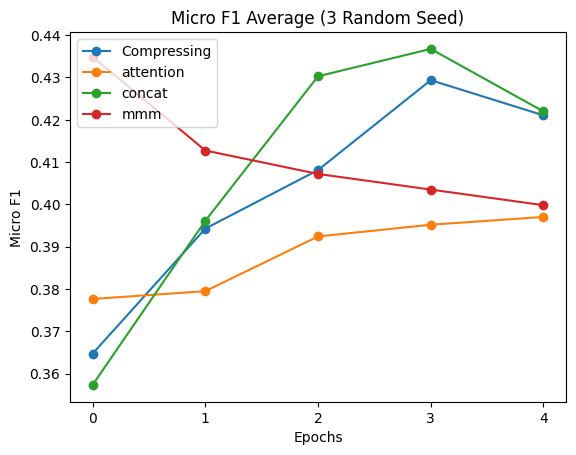

In [26]:
plt.plot(data_compressing['Micro-F1'], marker="o", label="Compressing")
plt.plot(data_attention['Micro-F1'], marker="o", label="attention")
plt.plot(data_concat['Micro-F1'], marker="o", label="concat")
plt.plot(data_mmm['Micro-F1'], marker="o", label="mmm")

plt.title("Micro F1 Average (3 Random Seed)")
plt.xlabel("Epochs")
plt.ylabel("Micro F1")
plt.legend(loc = "upper left")
plt.xticks(data_compressing.index)

([<matplotlib.axis.XTick at 0x7fa292576df0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

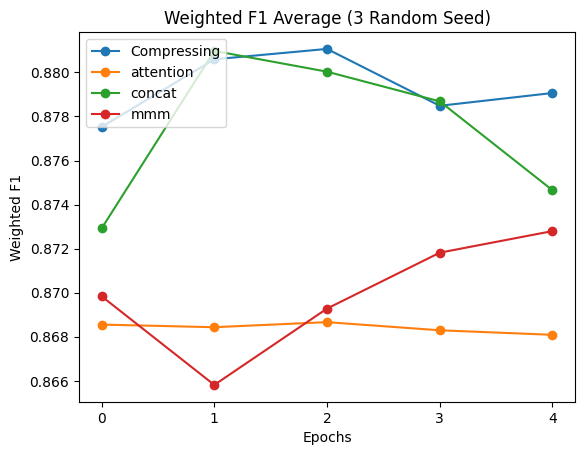

In [27]:
plt.plot(data_compressing['Weighted-F1'], marker="o", label="Compressing")
plt.plot(data_attention['Weighted-F1'], marker="o", label="attention")
plt.plot(data_concat['Weighted-F1'], marker="o", label="concat")
plt.plot(data_mmm['Weighted-F1'], marker="o", label="mmm")

plt.title("Weighted F1 Average (3 Random Seed)")
plt.xlabel("Epochs")
plt.ylabel("Weighted F1")
plt.legend(loc = "upper left")
plt.xticks(data_compressing.index)

### Concat vs Add

([<matplotlib.axis.XTick at 0x7fa29253e910>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

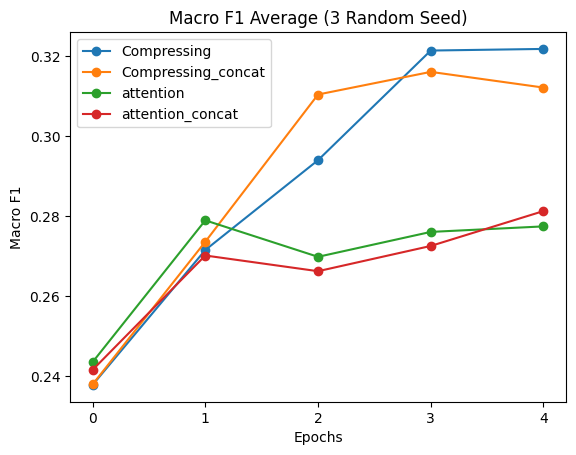

In [28]:
plt.plot(data_compressing['Macro-F1'], marker="o", label="Compressing")
plt.plot(data_compressing_concat['Macro-F1'], marker="o", label="Compressing_concat")
plt.plot(data_attention['Macro-F1'], marker="o", label="attention")
plt.plot(data_attention_concat['Macro-F1'], marker="o", label="attention_concat")

plt.title("Macro F1 Average (3 Random Seed)")
plt.xlabel("Epochs")
plt.ylabel("Macro F1")
plt.legend(loc = "upper left")
plt.xticks(data_compressing.index)

([<matplotlib.axis.XTick at 0x7fa29010e430>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

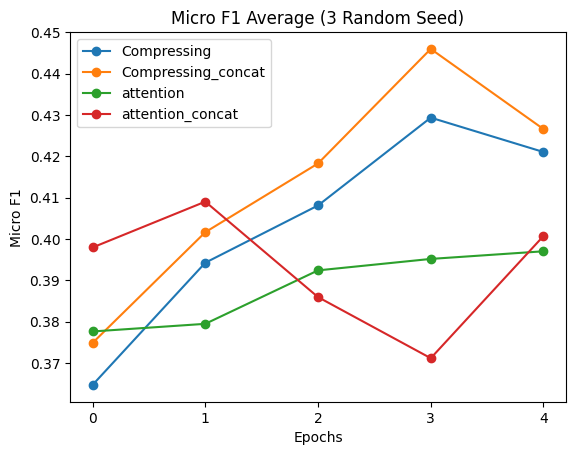

In [29]:
plt.plot(data_compressing['Micro-F1'], marker="o", label="Compressing")
plt.plot(data_compressing_concat['Micro-F1'], marker="o", label="Compressing_concat")
plt.plot(data_attention['Micro-F1'], marker="o", label="attention")
plt.plot(data_attention_concat['Micro-F1'], marker="o", label="attention_concat")

plt.title("Micro F1 Average (3 Random Seed)")
plt.xlabel("Epochs")
plt.ylabel("Micro F1")
plt.legend(loc = "upper left")
plt.xticks(data_compressing.index)

([<matplotlib.axis.XTick at 0x7f1bb0275b20>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

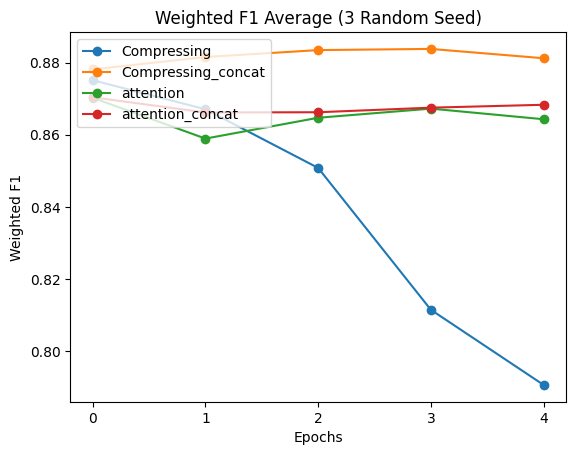

In [77]:
plt.plot(data_compressing['Weighted-F1'], marker="o", label="Compressing")
plt.plot(data_compressing_concat['Weighted-F1'], marker="o", label="Compressing_concat")
plt.plot(data_attention['Weighted-F1'], marker="o", label="attention")
plt.plot(data_attention_concat['Weighted-F1'], marker="o", label="attention_concat")

plt.title("Weighted F1 Average (3 Random Seed)")
plt.xlabel("Epochs")
plt.ylabel("Weighted F1")
plt.legend(loc = "upper left")
plt.xticks(data_compressing.index)